In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import math

# from matplotlib import rc
# rc('text', usetex=True)
pd.set_option('max_colwidth',140)

plt.style.use('bmh')
%matplotlib inline

## Question 1

## Part A

$$\text{The conjugate prior for a poisson distribution is the gamma distribution}$$

$$\pi(\lambda) = \lambda ^{\alpha - 1}e^{-\beta \lambda}$$
$$\Pr(Y \;|\;\lambda) = \lambda^{\sum y_i}e ^ {-\lambda n}$$
$$\Pr(\lambda \;| \; Y) = \pi(\lambda)\Pr(Y \;|\;\lambda)$$ 
$$= \lambda^{\alpha + \sum y_i - 1}e ^ {-\lambda (n + \beta)}$$

$$\text{The posterior is then}$$

$$\text{Gamma}(\alpha + \sum y_i, n + \beta)$$

## Part B

### Prior

$Var(X) = 5 = \frac{\alpha}{\beta ^ 2}$

$E(X) = 5 = \frac{\alpha}{\beta}$

Solving for $\alpha$ and $\beta$

$\alpha = 5$

$\beta = 1$

### Posterior

Posterior $\alpha$ = 57

Posterior $\beta$ = 11

Posterior Mean: 5.18

Posterior Var: .47

In [2]:
chiData = np.asarray([5, 4, 6, 5, 5, 6, 5, 7, 3, 6], dtype=int)

In [3]:
alpha_0 = 5.
beta_0 = 1.

postAlpha = chiData.sum() + alpha_0
postBeta = len(chiData) + beta_0
print("Posterior Alpha: {}".format(postAlpha))
print("Posterior Beta: {}".format(postBeta))

postVar = postAlpha / (postBeta ** 2)
postMean = postAlpha / postBeta
print("Posterior Var: {}".format(postVar))
print("Posterior Mean: {}".format(postMean))

Posterior Alpha: 57.0
Posterior Beta: 11.0
Posterior Var: 0.471074380165
Posterior Mean: 5.18181818182


In [4]:
def poisson_likelihood(data, lambdas):
    """
    \lambda ** (\sum y_i) * exp(-n * \lambda)
    """
    probs = []
    norm = np.prod(chiData)
    for lam in lambdas:
        rv = lam ** data.sum() * np.exp(- len(data) * lam)
        probs.append(rv / norm)
    return np.asarray(probs).T

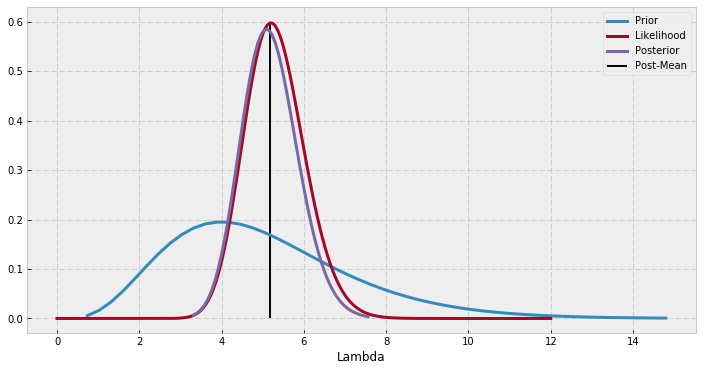

In [5]:
plt.figure(figsize=(12, 6))
# Prior

prior_dist = stats.gamma(alpha_0, scale=1. / beta_0)
prior_range = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999))
prior_vals = prior_dist.pdf(prior_range)
plt.plot(prior_range, prior_vals, label="Prior", lw=3)
# Likelihood
params = np.linspace(0, 12, 200)
likelihood = poisson_likelihood(chiData, params)
plt.plot(params, likelihood / np.exp(18.), label='Likelihood', lw=3)
# Posterior
post_dist = stats.gamma(alpha_0 + chiData.sum(), scale= 1. / ( beta_0 + len(chiData)))  # Inverse b/c it utilizes scale/shape form
post_range = np.linspace(post_dist.ppf(0.001), post_dist.ppf(0.999))
post_vals = post_dist.pdf(post_range)
plt.plot(post_range, post_vals, label="Posterior", lw=3)
plt.vlines(postMean, 0, 0.6, label='Post-Mean')
plt.xlabel('Lambda')
plt.legend()
plt.show()

# Question 2

## Part A

$$Pr(\tau \; | \; X) = \frac{L(X \;|\; \tau)\pi(\tau)}{Pr(X)}$$

$$L(X \;| \; \tau) = \prod^n_i \sqrt{\frac{\tau}{2\pi}}\exp{\Big(\frac{-\tau}{2}x_i^2}\Big)$$

$$\text{by multiplying out}$$

$$ = \Big(\frac{\tau}{2\pi}\Big)^{\frac{n}{2}} \exp{\Big(\frac{-\tau}{2}\sum_i^nx_i^2}\Big)$$

## Part B

$$\pi(\tau) = \sqrt{\mathcal{I}({\tau})} = \sqrt{-E\big[\frac{\partial^2}{\partial \tau^2}\log(L(\tau \;|\;X)\big]}$$

$$\text{Solving for the second derivative}$$

$$\frac{\partial^2}{\partial \tau^2}\log(L(\tau \;|\;X) = \frac{\partial^2}{\partial \tau^2}\Big[\frac{n}{2}\ln\tau - \frac{n}{2}\ln2\pi - \frac{\tau}{2}\sum_i^nx_i^2 \Big] = \frac{-n}{2\tau^2}$$

$$\text{Plugging that in to the original equation}$$

$$\pi(\tau) = \sqrt{\frac{n}{2\tau}^2} = \frac{1}{\tau}\sqrt{\frac{n}{2}} \propto \frac{1}{\tau}$$

## Part C

$$Pr(\tau \; | \; X) = \frac{L(X \;| \; \tau)\pi(\tau)}{Pr(X)}$$

$$Pr(\tau \; | \; X) \propto \Big(\frac{\tau}{2\pi}\Big)^{\frac{n}{2} - 1}\exp \Big(\frac{-n}{2}\sum_i^nx_i^2 \Big)$$

$$\text{this has the same form as gamma distribution, but $\beta$ also be inverted depending on formulation}$$

$$\mathrm{Gamma}\big(\frac{n}{2}, \frac{\sum x^2 }{2}\big)$$

In [6]:
q2data = np.array([2.72, 1.65, 0.44, 1.62, 0.27, 2.22])

In [7]:
mleMean = (q2data ** 2).sum() / len(q2data)
postMean = 1 / (len(q2data) / (q2data ** 2).sum())

In [8]:
mleMean

2.9900333333333333

In [9]:
postMean

2.9900333333333338

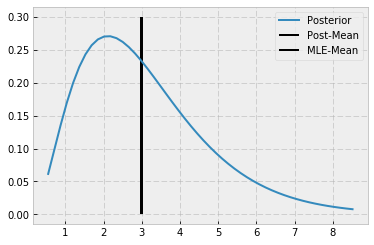

In [10]:
gam2 = stats.gamma(len(q2data)/2., 2. / np.sum(q2data ** 2)) 
points = np.linspace(gam2.ppf(0.01), gam2.ppf(0.99))
plt.plot(points, gam2.pdf(points), label='Posterior')
plt.vlines(postMean + 0.01, 0, 0.3, label='Post-Mean')
plt.vlines(mleMean - 0.01, 0, 0.3, label='MLE-Mean')
plt.legend()
plt.show()

## Question 3

In [11]:
df = pd.read_table('http://health.bsd.uchicago.edu/yji/Bayes2017/homework/calirain.txt', sep=r"\s*", 
                   names=['index', 'city', 'precip', 'altitude', 'latitude', 'distance'], engine='python')
df.set_index("index", inplace=True)
df["constant"] = 1

In [12]:
df.head()

,city,precip,altitude,latitude,distance,constant
index,,,,,,
1,Eureka,39.57,43,40.8,1,1
2,RedBluff,23.27,341,40.2,97,1
3,Thermal,18.20,4152,33.8,70,1
4,FortBragg,37.48,74,39.4,1,1
5,SodaSprings,49.26,6752,39.3,150,1


## Part A

Utilizing the BIC metric, it can be seen that the utilizing all of the parameters produces the best results

In [13]:
X = df.drop(["precip", "city"], axis=1) 
X = X[X.columns[::-1]]
Y = df['precip']

In [14]:
cols = list(X.columns)
combs = [['constant']]
for a in cols[1:]:
    for b in cols[1:]:
        for c in cols[1:]:
            combs.append(list(set([a, b, c, 'constant'])))
combs = np.unique(combs)

In [15]:
results = []
for exog in combs:
    results.append((exog, OLS(Y, df[exog]).fit().bic))

In [16]:
pd.DataFrame.from_records(sorted(results, key=lambda x:x[1]), columns=["Columns", "BIC"])

,Columns,BIC
0,"[latitude, distance, altitude, constant]",238.853895
1,"[latitude, distance, constant]",246.257895
2,"[latitude, constant]",247.430201
3,"[latitude, altitude, constant]",249.447222
4,"[distance, altitude, constant]",251.809914
5,[constant],256.161162
6,"[altitude, constant]",256.693186
7,"[distance, constant]",258.207984


In [17]:
pred = OLS(Y, X).fit().predict(X)

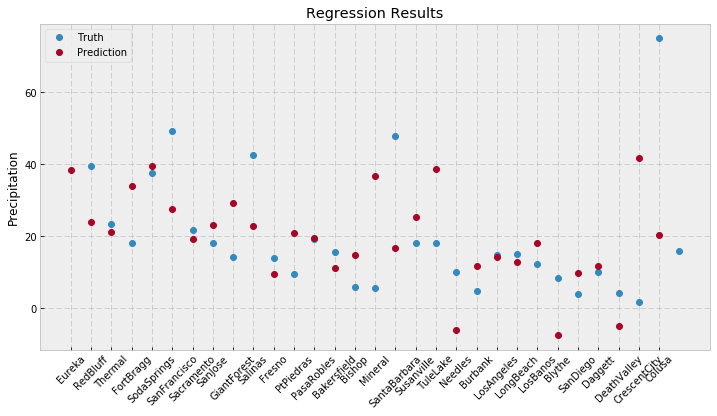

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(Y, label="Truth", marker='o', ls=' ')
plt.plot(pred, label='Prediction', marker='o', ls=' ')
plt.xticks(range(len(df)), df["city"], rotation=45)
plt.ylabel('Precipitation')
plt.title("Regression Results")
plt.legend()
plt.show()

## Part B

Using a MCMC model for regression. I also normalized the variables because I found that it helped with convergence.

In [19]:
Xnew = X.values
Ynew = Y.values
Xnew = (Xnew - Xnew.mean(axis=0)) / (Xnew.std(axis=0) + 0.00001)
Xnew[:, 0] = 1

In [20]:
def jeffreys(value):
    return ( 1 / value)

with pm.Model() as model:
    beta = pm.Flat('beta', shape=4) #pm.DensityDist('beta', jeffreys, testval=4, shape=4) # pm.Uniform('beta', -1e5, 1e5, shape=4)
    sigma = pm.DensityDist('sigma', jeffreys, testval=4)
    mu = pm.math.dot(Xnew, beta)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Ynew)
    step = pm.Metropolis()
    start = pm.find_MAP()
    trace = pm.sample(80000, step=step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 112.527685
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 80000/80000 [00:20<00:00, 3997.02it/s]


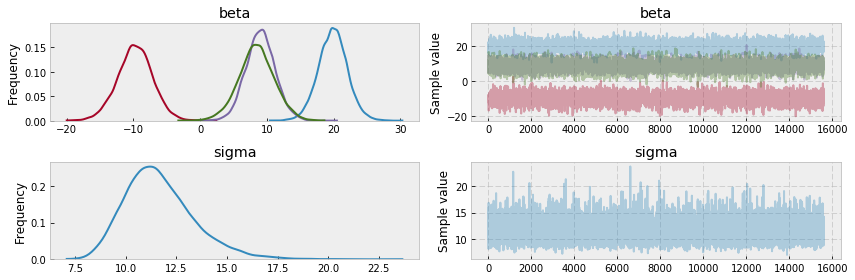

In [21]:
burned_trace = trace[2000::5]
pm.traceplot(burned_trace)
plt.show()

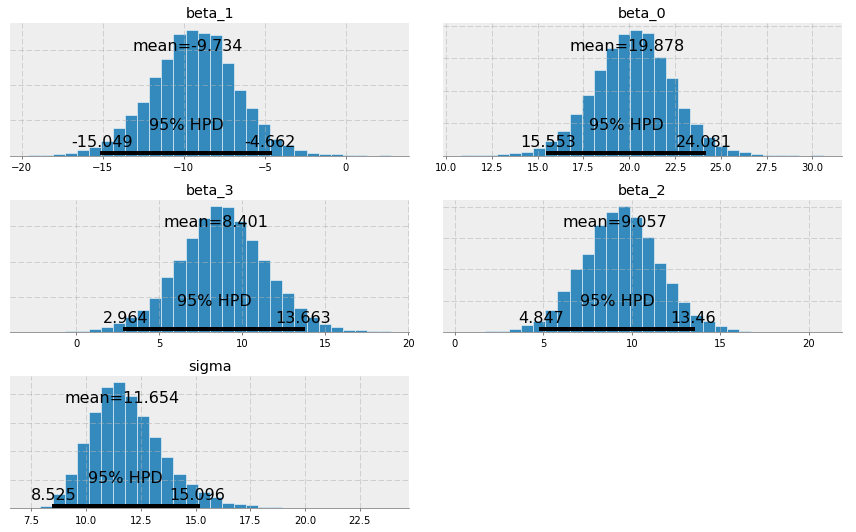

In [22]:
_ = pm.plot_posterior(burned_trace)

### Model Predictions

Using a posterior predictive distribution

In [23]:
ppc = pm.sample_ppc(burned_trace, samples=500, model=model, size=300, progressbar=False)

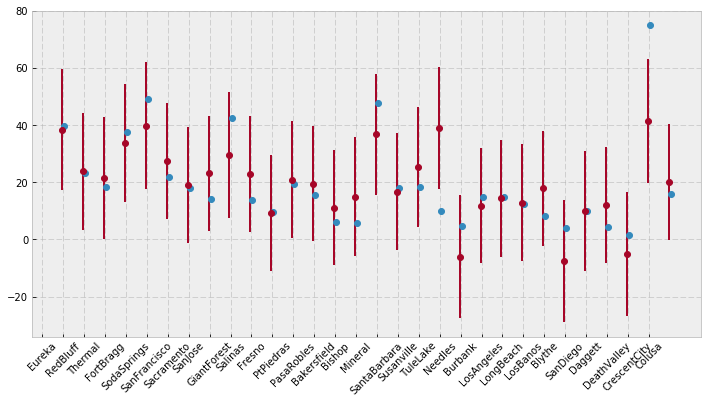

In [24]:
plt.figure(figsize=(12, 6))
plt.errorbar(df.index + 0.05, df["precip"], label="Truth", linestyle='', marker='o')
plt.errorbar(df.index - 0.05, ppc["Y_obs"].mean(axis=(0,1)), yerr=ppc["Y_obs"].std((0, 1)) * 1.67, 
             label='Posterior Mean', linestyle='', marker='o')
plt.xticks(range(len(df)), df["city"], rotation=45)
plt.show()

## Part C

The best model does change when including the interaction terms. Incuding the interaction of distance of latitude 

In [25]:
X = df.drop(["precip", "city"], axis=1) 
X = X[X.columns[::-1]]
Y = df['precip']

In [26]:
X['alt-dist'] = X['altitude'] * X['distance']
X['alt-lat'] = X['altitude'] * X['latitude']
X['dist-lat'] = X['distance'] * X['latitude']

I recognize that this was a naive approach to producing the combinations of columns

In [27]:
cols = list(X.columns)
cols.remove('constant')
combs = []
for a in cols:
    for b in cols[1:]:
        for c in cols[2:]:
            for d in cols[3:]:
                for e in cols[4:]:
                    for f in cols[5:]:
                        combs.append(list(set([a, b, c, d, e,f,'constant'])))
combs = np.unique(combs)

In [28]:
results = []
for exog in combs:
    results.append((exog, OLS(Y, X[exog]).fit().bic))

In [29]:
pd.DataFrame.from_records(sorted(results, key=lambda x:x[1]), columns=["Columns", "BIC"])\
.drop([0, 1, 4]).reset_index().drop('index', axis=1).head()

,Columns,BIC
0,"[latitude, distance, altitude, constant, dist-lat]",231.949833
1,"[distance, alt-lat, constant, altitude, latitude, dist-lat]",233.894359
2,"[distance, constant, altitude, latitude, dist-lat, alt-dist]",234.416500
3,"[distance, alt-lat, constant, altitude, latitude, dist-lat, alt-dist]",236.864150
4,"[latitude, constant, altitude, dist-lat]",236.892583


Bayesian approach to best model

In [30]:
X.mean(axis=0)

constant         1.000000
distance        78.700000
latitude        37.026667
altitude      1375.300000
alt-dist    188863.400000
alt-lat      52171.246667
dist-lat      2942.823333
dtype: float64

In [31]:
Xnew = X[['constant', 'latitude', 'distance', 'altitude', 'dist-lat']].values
Ynew = Y.values
Xnew = (Xnew - Xnew.mean(axis=0)) / (Xnew.std(axis=0) + 0.00001)
Xnew[:, 0] = 1

In [32]:
def jeffreys(value):
    return ( 1 / value)

with pm.Model() as model:
    beta = pm.Flat('beta', shape=5)
    sigma = pm.DensityDist('sigma', jeffreys, testval=4)
    mu = pm.math.dot(Xnew, beta)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Ynew)
    step = pm.Metropolis()
    start = pm.find_MAP()
    trace = pm.sample(100000, step=step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 107.356886
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39


100%|██████████| 100000/100000 [00:24<00:00, 4088.32it/s]


Despite the trace plots showing a significant amount of autocorrelation it appears as though the beta values have converged to neat distributions

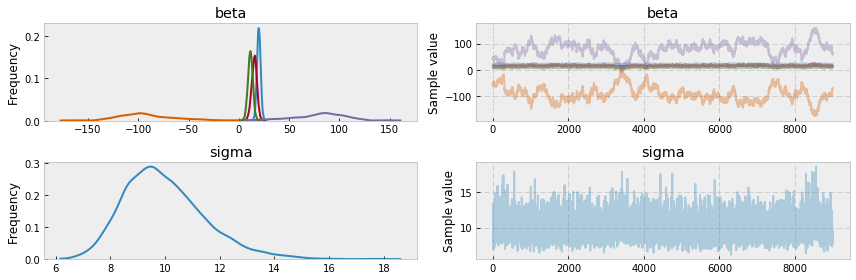

In [33]:
burned_trace2 = trace[10000::10]
pm.traceplot(burned_trace2)
plt.show()

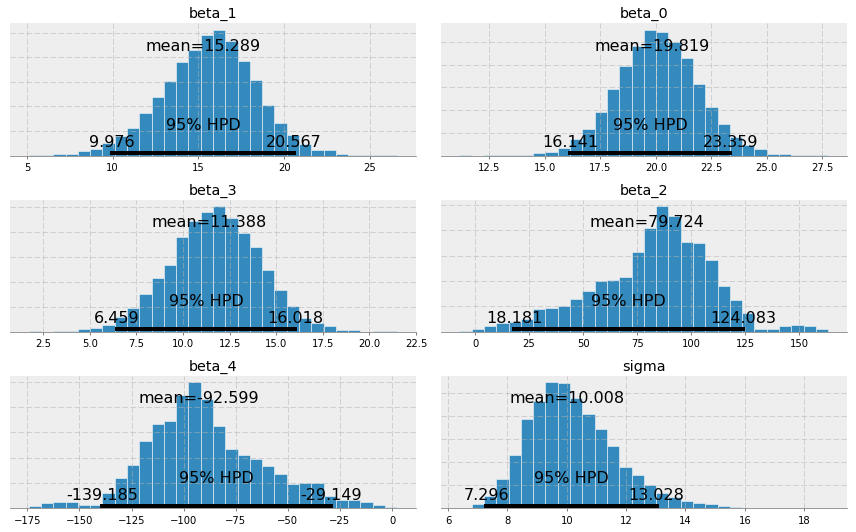

In [34]:
_ = pm.plot_posterior(burned_trace2)

In [35]:
ppc2 = pm.sample_ppc(burned_trace2, samples=500, model=model, size=300, progressbar=False)

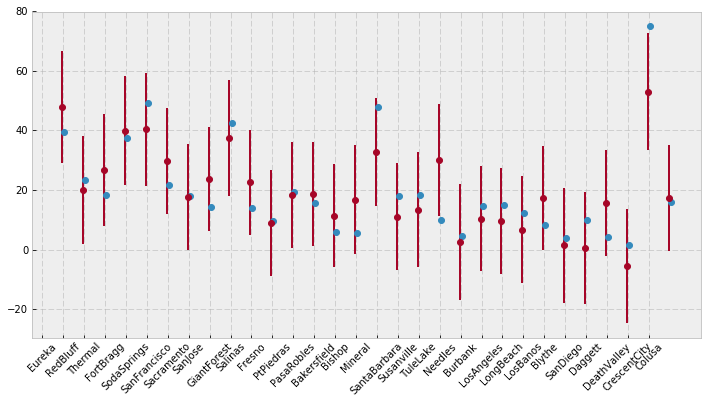

In [36]:
plt.figure(figsize=(12, 6))
plt.errorbar(df.index + 0.05, df["precip"], label="Truth", linestyle='', marker='o')
plt.errorbar(df.index - 0.05, ppc2["Y_obs"].mean(axis=(0,1)), yerr=ppc2["Y_obs"].std((0, 1)) * 1.67, 
             label='Posterior Mean', linestyle='', marker='o')
plt.xticks(range(len(df)), df["city"], rotation=45)
plt.show()

# Question 4

The derivation is on a separate piece of paper. In general, as $\lambda$ increases the factor decreases. However, as the heatmaps indicate the results are more nuanced for small values of $\sigma^2$ and $\Sigma^2$. As the ratio of $\frac{\sigma^2}{\Sigma^2}$ increases the ratio increases except in the case of very small $\lambda$. When the ratio approaches $0$ there is less evidence for the alternate hypothesis and the opposite is true as the ratio increases.

$$\Big[\sqrt{\frac{2\sigma^2}{\sum^2 + \sigma^2}}\exp\Big(\frac{\lambda^2\sum^2}{2(\sigma^2 + \sum^2}\Big)\Big]^{-1}$$

In [14]:
def factor(lam, sig, cov):
    
    const =  math.sqrt((2. * sig) / (cov + sig))
    kern = np.exp((lam * cov ) / (2. * (sig + cov)))
    return 1. / (const * kern)

In [74]:
obs = 400
lambdas = np.linspace(1.01, 20, num=obs)
sigmas = np.linspace(1, 15, num=obs)
covs = np.linspace(1, 15, num=obs)

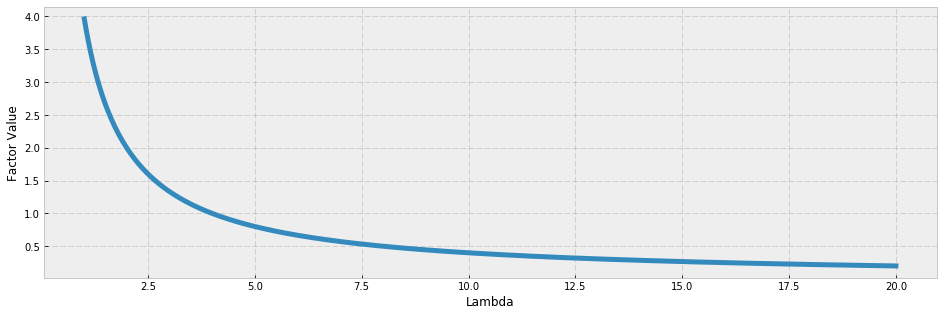

In [75]:
vals = []
cords = []
for i, lam in enumerate(lambdas):
    cords.append([lam])
    vals.append(thing(lam, sigmas[50], covs[50]))

plt.figure(figsize=(16, 5))
plt.plot(cords, vals, lw=5)
plt.ylabel('Factor Value')
plt.xlabel('Lambda')
plt.show()

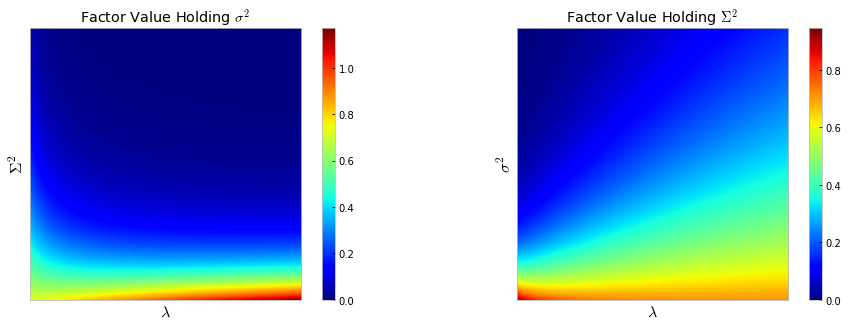

In [106]:
plt.figure(figsize=(16, 5))

vals = np.zeros((obs, obs))
cords = []
for i, lam in enumerate(lambdas):
    for k, cov in enumerate(covs):
        cords.append([lam, cov])
        vals[i,k] = factor(lam, sigmas[50], cov)
        
cords = np.array(cords)
_ = plt.subplot(121).imshow(vals, interpolation='none', origin='lower', cmap=plt.cm.jet, vmin=0)
plt.title('Factor Value Holding $\sigma^2$')

plt.colorbar(_)
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('$\Sigma^2$', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.grid(None)

vals = np.zeros((obs, obs))
cords = []
for i, lam in enumerate(lambdas):
    for j, sig in enumerate(sigmas):
        cords.append([lam, cov])
        vals[i,j] = factor(lam, sig, covs[50])

cords = np.array(cords)
_ = plt.subplot(122).imshow(vals, interpolation='none', origin='lower', cmap=plt.cm.jet, vmin=0)
plt.title('Factor Value Holding $\Sigma^2$')
plt.colorbar(_)
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('$\sigma^2$', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.grid(None)

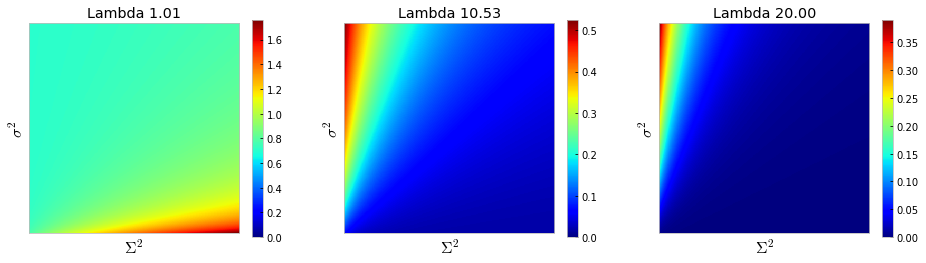

In [103]:
vals = np.zeros((obs, obs))
cords = []
for j, sig in enumerate(sigmas):
    for k, cov in enumerate(covs):
        cords.append([sig, cov])
        vals[j,k] = factor(lambdas[0], sig, cov)
cords = np.array(cords)

plt.figure(figsize=(16,4))

_ = plt.subplot(131).imshow(vals, interpolation='none', origin='lower', cmap=plt.cm.jet, vmin=0)
plt.title('Lambda {:.2f}'.format(lambdas[0]))
plt.colorbar(_)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\Sigma^2$', fontsize=16)
plt.ylabel('$\sigma^2$', fontsize=16)
plt.grid(None)

vals = np.zeros((obs, obs))
cords = []
for j, sig in enumerate(sigmas):
    for k, cov in enumerate(covs):
        cords.append([sig, cov])
        vals[j,k] = factor(lambdas[200], sig, cov)
cords = np.array(cords)


_ = plt.subplot(132).imshow(vals, interpolation='none', origin='lower', cmap=plt.cm.jet, vmin=0)
plt.title('Lambda {:.2f}'.format(lambdas[200]))
plt.colorbar(_)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\Sigma^2$', fontsize=16)
plt.ylabel('$\sigma^2$', fontsize=16)
plt.grid(None)


vals = np.zeros((obs, obs))
cords = []
for j, sig in enumerate(sigmas):
    for k, cov in enumerate(covs):
        cords.append([sig, cov])
        vals[j,k] = factor(lambdas[-1], sig, cov)
cords = np.array(cords)

_ = plt.subplot(133).imshow(vals, interpolation='none', origin='lower', cmap=plt.cm.jet, vmin=0)
plt.title('Lambda {:.2f}'.format(lambdas[-1]))

plt.colorbar(_)
plt.xticks([])
plt.yticks([])
plt.xlabel('$\Sigma^2$', fontsize=16)
plt.ylabel('$\sigma^2$', fontsize=16)
plt.grid(None)